In [1]:
import pandas
import numpy
import librosa
import requests
import seaborn
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
labels = ['dishwasher', 'washing_machine', 'shower', 'washing_hands', 'flushing_toilet']

In [3]:
# Get list of all recordings
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"],
        "mfcc_mean": None,
        "mfcc_var": None
    })

dataframe = pandas.json_normalize(recordings)

dataframe.head()

,path,label,environment,mfcc_mean,mfcc_var
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg,None,None
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg,None,None
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg,None,None
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg,None,None
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg,None,None


In [4]:
# Function to extract mean and variance of the mfcc
def preprocess(dataframe):
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate)
        dataframe.at[index, "mfcc_mean"] = numpy.mean(mfcc)
        dataframe.at[index, "mfcc_var"] = numpy.var(mfcc)
        
    return dataframe

dataframe = preprocess(dataframe)

119it [02:42,  1.37s/it]


In [5]:
# Extract separate dataframes for environments marsberg and duesseldorf
dataframe_marsberg = dataframe[dataframe["environment"] == "marsberg"]
dataframe_duesseldorf = dataframe[dataframe["environment"] == "duesseldorf"]

In [6]:
# Prepare and split data for training
y = dataframe_marsberg['label']
x = dataframe_marsberg.drop(['label', 'path', 'environment'], axis=1)

y.replace(labels,[0, 1, 2, 3, 4], inplace=True)

cols = x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x)
x = pandas.DataFrame(np_scaled, columns = cols)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [7]:
model = SVC(
    kernel="rbf",
    gamma=50,
    probability=True
).fit(x_train, y_train)

In [8]:
test_predictions = model.predict(x_test)
print(accuracy_score(y_test, test_predictions))

1.0


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

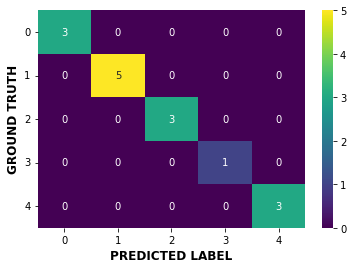

In [9]:
def confusion_matrix_table(y_true, y_pred):
    labels = sklearn.utils.multiclass.unique_labels(y_test)
    columns = [f'{label}' for label in labels]
    index = [f'{label}' for label in labels]
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    table = pandas.DataFrame(confusion_matrix, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0)
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_test, test_predictions)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


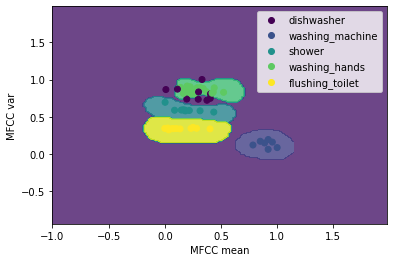

In [10]:
h = .02

cmap_primary = plt.cm.get_cmap('viridis')
cmap_secondary = cmap_primary

x_min, x_max = x_train["mfcc_mean"].min() - 1, x_train["mfcc_mean"].max() + 1
y_min, y_max = x_train["mfcc_var"].min() - 1, x_train["mfcc_var"].max() + 1

xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h), numpy.arange(y_min, y_max, h))

Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

contourf = plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_secondary)
scatter = plt.scatter(x_train['mfcc_mean'], x_train['mfcc_var'], c=y_train, cmap=cmap_primary)
plt.xlabel('MFCC mean')
plt.ylabel('MFCC var')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend(handles=scatter.legend_elements()[0], labels=labels, loc='best');

In [12]:
# Calculate accuracy on data from duesseldorf
y_duesseldorf = dataframe_duesseldorf['label']
x_duesseldorf = dataframe_duesseldorf.drop(['label', 'path', 'environment'], axis=1)

y_duesseldorf.replace(labels,[0, 1, 2, 3, 4], inplace=True)

cols = x_duesseldorf.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x_duesseldorf)
x_duesseldorf = pandas.DataFrame(np_scaled, columns = cols)

test_duesseldorf_predictions = model.predict(x_duesseldorf)
print(accuracy_score(y_duesseldorf, test_duesseldorf_predictions))

0.14583333333333334


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

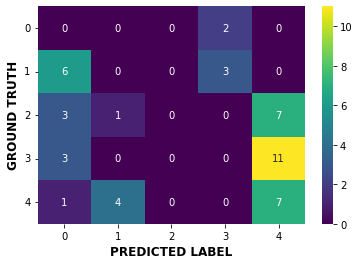

In [13]:
confusion_matrix_plot(y_duesseldorf, test_duesseldorf_predictions)